# RNN 用于时间序列的分析
前面我们讲到使用 RNN 做简单的图像分类的问题，但是 RNN 并不擅长此类问题，下面我们讲一讲如何将 RNN 用到时间序列的问题上，因为对于时序数据，后面的数据会用到前面的数据，LSTM 的记忆特性非常适合这种场景。

首先我们可以读入数据，这个数据是 10 年飞机月流量，可视化得到下面的效果。

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data_csv = pd.read_csv('D:/pytorch/chapter5_RNN/time-series/data.csv', usecols=[1])

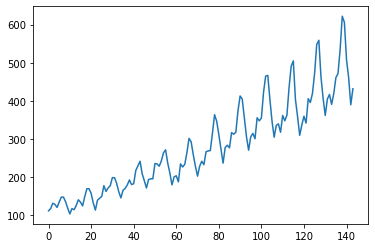

In [5]:
plt.plot(data_csv)

首先我们进行预处理，将数据中 `na` 的数据去掉，然后将数据标准化到 0 ~ 1 之间。

In [20]:
# 数据预处理
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
print(dataset)
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))
print(dataset)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


接着我们进行数据集的创建，我们想通过前面几个月的流量来预测当月的流量，比如我们希望通过前两个月的流量来预测当月的流量，我们可以将前两个月的流量当做输入，当月的流量当做输出。同时我们需要将我们的数据集分为训练集和测试集，通过测试集的效果来测试模型的性能，这里我们简单的将前面几年的数据作为训练集，后面两年的数据作为测试集。

In [11]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [22]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)
print(data_Y)

[[0.25482625]
 [0.24903475]
 [0.23359074]
 [0.26061776]
 [0.2857143 ]
 [0.2857143 ]
 [0.26254827]
 [0.22972973]
 [0.2007722 ]
 [0.22779922]
 [0.22200772]
 [0.24324325]
 [0.27220076]
 [0.26061776]
 [0.24131274]
 [0.28764477]
 [0.32818532]
 [0.32818532]
 [0.30501932]
 [0.25675675]
 [0.22007722]
 [0.27027026]
 [0.27992278]
 [0.28957528]
 [0.34362933]
 [0.3146718 ]
 [0.33204633]
 [0.34362933]
 [0.38416988]
 [0.38416988]
 [0.35521236]
 [0.3127413 ]
 [0.2818533 ]
 [0.32046333]
 [0.33011582]
 [0.34749034]
 [0.37258688]
 [0.34942085]
 [0.35328186]
 [0.4208494 ]
 [0.44401544]
 [0.46718147]
 [0.4034749 ]
 [0.36872587]
 [0.33204633]
 [0.37451738]
 [0.3783784 ]
 [0.3783784 ]
 [0.45559844]
 [0.45366797]
 [0.44208494]
 [0.46911198]
 [0.5096525 ]
 [0.52509654]
 [0.45752895]
 [0.4073359 ]
 [0.34749034]
 [0.3880309 ]
 [0.3938224 ]
 [0.36293435]
 [0.45366797]
 [0.43822393]
 [0.45173746]
 [0.5096525 ]
 [0.58301157]
 [0.56563705]
 [0.5       ]
 [0.44208494]
 [0.3918919 ]
 [0.44208494]
 [0.46718147]
 [0.44

In [10]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

最后，我们需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，而输入的 feature 就是我们希望依据的几个月份，这里我们定的是两个月份，所以 feature 就是 2.

In [11]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [12]:
from torch import nn
from torch.autograd import Variable

这里定义好模型，模型的第一部分是一个两层的 RNN，每一步模型接受两个月的输入作为特征，得到一个输出特征。接着通过一个线性层将 RNN 的输出回归到流量的具体数值，这里我们需要用 `view` 来重新排列，因为 `nn.Linear` 不接受三维的输入，所以我们先将前两维合并在一起，然后经过线性层之后再将其分开，最后输出结果。

In [16]:
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [20]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

定义好网络结构，输入的维度是 2，因为我们使用两个月的流量作为输入，隐藏层的维度可以任意指定，这里我们选的 4

In [21]:
# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

Epoch: 100, Loss: 0.00395
Epoch: 200, Loss: 0.00337
Epoch: 300, Loss: 0.00259
Epoch: 400, Loss: 0.00149
Epoch: 500, Loss: 0.00109
Epoch: 600, Loss: 0.00106
Epoch: 700, Loss: 0.00097
Epoch: 800, Loss: 0.00092
Epoch: 900, Loss: 0.00087
Epoch: 1000, Loss: 0.00105


训练完成之后，我们可以用训练好的模型去预测后面的结果

In [22]:
net = net.eval() # 转换成测试模式

In [46]:
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果

In [47]:
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

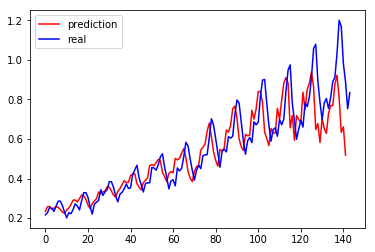

In [49]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

这里蓝色的是真实的数据集，红色的是预测的结果，我们能够看到，使用 lstm 能够得到比较相近的结果，预测的趋势也与真实的数据集是相同的，因为其能够记忆之前的信息，而单纯的使用线性回归并不能得到较好的结果，从这个例子也说明了 RNN 对于序列有着非常好的性能。

**小练习：试试改变隐藏状态输出的特征数，看看有没有什么改变，同时试试使用简单的线性回归模型，看看会得到什么样的结果**